In [3]:
from Bio import Entrez
from Bio import Medline
import pandas as pd
import time
import numpy as np
from ratelimiter import RateLimiter
import pubmed_parser as pp
Entrez.email = 'amanda.sawyer@nih.gov'
api_key = '86d72be66a4381e2e22c704615cbb9620c08'

In [ ]:
proposedTermsPath = 'mesh-proposed-terms.csv'
proposedTerms = pd.read_csv(proposedTermsPath)

### 1. Title and Title/Abstract Posting from PubMed
**Method 1: Testing Efficiency by using apply() and RateLimiter**

In [ ]:
#define functions for title and title/abstract
#RateLimiter limits to max of 10 calls per second using my NCBI key, per their requirements: https://ncbiinsights.ncbi.nlm.nih.gov/2017/11/02/new-api-keys-for-the-e-utilities/
#Find information on RateLimiter here: https://pypi.org/project/ratelimiter/
#Find information on Pandas apply() function here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

@RateLimiter(max_calls=10, period=1)
def getPubMedTitleTotal (term):
    termCounts = 0
    
    try:
        searchstring = term+' [ti]'
        handle = Entrez.esearch(db='pubmed', term=searchstring)
        result = Entrez.read(handle)
        handle.close()
        termCounts = result['Count']
    except:
        print("Error:", searchstring)
            
    return termCounts

@RateLimiter(max_calls=10, period=1)
def getPubMedTIABTotal (term):
    termCounts = 0
    
    try:
        searchstring = term+' [tiab]'
        handle = Entrez.esearch(db='pubmed', term=searchstring)
        result = Entrez.read(handle)
        handle.close()
        termCounts = result['Count']
    except:
        print("Error:", searchstring)
            
    return termCounts

In [ ]:
%%time
#use apply(), and Python magic time function
proposedTerms['Title Count'] = proposedTerms['term'].apply(getPubMedTitleTotal)
proposedTerms['Title Abstract Count'] = proposedTerms['term'].apply(getPubMedTIABTotal)

In [ ]:
proposedTerms

**Method 2 - Original Method using iteration instead of apply.**

In [ ]:
def getPubMedtotal(searchstring):
    thingtoreturn=0

    time.sleep(3)
    try:
        handle = Entrez.esearch(db="pubmed", term=searchstring, retmax = 1000)
        result = Entrez.read(handle)
        handle.close()
        thingtoreturn=result["Count"]
    except:
        print("Error:",searchstring)

    return thingtoreturn

In [ ]:
List_XLSX = pd.read_csv(proposedTermsPath, index_col=None)

In [ ]:
%%time
List_XLSX['TitleSearchTotal']=0
List_XLSX['TIABSearchTotal']=0

for index,row in List_XLSX.iterrows():
    List_XLSX.loc[index,'TitleSearchTotal']=getPubMedtotal(row['term'] + "[ti]")
    if index and not index % 250:
        print(index,"records processed")
print("Done.")

 
for index,row in List_XLSX.iterrows():
    List_XLSX.loc[index,'TIABSearchTotal']=getPubMedtotal(row['term'] + "[tiab]")
    if index and not index % 100:
        print(index,"records processed")
print("Done.")

In [ ]:
List_XLSX

### 2. PI and MN from PubMed

In [4]:
@RateLimiter(max_calls=10, period=1)
def getPMIDs (term) :
    handle_test = Entrez.esearch(db='pubmed', term=term+'[ti]', retmax = 1000)
    result_test = Entrez.read(handle_test)
    handle_test.close()
    pmid = result_test['IdList']
    return pmid

@RateLimiter(max_calls=10, period=1)
def returnPMRecords (ids) :
    tester = []
    rate_limiter = RateLimiter(max_calls=3, period=1)

    for x in ids :
        with rate_limiter:
            tester.append(pp.parse_xml_web(x, save_xml=False))
    return tester

In [5]:
newterm = input("Enter search term:")
ids = getPMIDs(newterm)
tester = returnPMRecords(ids)

Enter search term:Default Mode Network


In [6]:
#created a df
newTermDF = pd.DataFrame(tester)
#split keywords on ;
newTermDF['keywordssplit'] = newTermDF.apply(lambda row: row.keywords.split(';'), axis = 1)
#each keyword gets its own row
newTermDF = newTermDF.explode('keywordssplit')
#created a df for frequency of terms
frequency = pd.DataFrame()
frequency['Term Frequency'] = newTermDF['keywordssplit'].value_counts()
frequency['Percentage'] = round((frequency['Term Frequency'] / newTermDF['keywordssplit'].value_counts().sum()) * 100, 2)
frequency[0:25]

**Exploring NLTK for frequnecy visualizations - not a viable option without modification**

In [ ]:
#set the number of top keywords you want to look at
top_N = 25

newTermDF['keywordssplit'] = newTermDF['keywordssplit'].str.replace('[^\w\s]','')

txt = newTermDF.keywordssplit.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

print('All frequencies, without STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
print(rslt)
print('=' * 60)

matplotlib.style.use('ggplot')

rslt.plot.bar()

### 3. Searching for Other Related Terms with Latent Dirichlet Allocation

In [21]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [22]:
#create df from title, abstract keywords. using data collected from 1,000 articles for pt. 2. example of "Default Mode Network"
ldadf = pd.DataFrame(tester)
ldadf = ldadf[['title', 'abstract', 'keywords']]

In [23]:
# data cleaning

#space out keywords, remove ;
ldadf['keywords'] = ldadf['keywords'].str.replace(";", " ")

#place everything in lowercase and remove punctuation
ldadf = ldadf.apply(lambda x: x.astype(str).str.lower())
def remove_punctuation(x):
    try:
        x = x.str.replace('[^\w\s]','') #might be worth exploring a str.translate option to save memory/time
    except:pass
    return x

ldadf = ldadf.apply(remove_punctuation)

#remove numbers from keywords
ldadf['keywords'] = ldadf['keywords'].str.replace('\d+', '  ')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

ldadf['title'] = ldadf.title.apply(lemmatize_text)
ldadf['abstract'] = ldadf.abstract.apply(lemmatize_text)
ldadf['keywords'] = ldadf.keywords.apply(lemmatize_text)

#remove stopwords
ldadf['title'] = ldadf['title'].map(lambda x: [t for t in x if t not in stopwords])
ldadf['abstract'] = ldadf['abstract'].map(lambda x: [t for t in x if t not in stopwords])
ldadf['keywords'] = ldadf['keywords'].map(lambda x: [t for t in x if t not in stopwords])

<>:10: DeprecationWarning: invalid escape sequence \w
<>:17: DeprecationWarning: invalid escape sequence \d
<>:10: DeprecationWarning: invalid escape sequence \w
<>:17: DeprecationWarning: invalid escape sequence \d
<>:10: DeprecationWarning: invalid escape sequence \w
<>:17: DeprecationWarning: invalid escape sequence \d
<ipython-input-23-695d00734ea2>:10: DeprecationWarning: invalid escape sequence \w
  x = x.str.replace('[^\w\s]','') #might be worth exploring a str.translate option to save memory/time
<ipython-input-23-695d00734ea2>:17: DeprecationWarning: invalid escape sequence \d
  ldadf['keywords'] = ldadf['keywords'].str.replace('\d+', '  ')


In [24]:
ldadf

,title,abstract,keywords
0,"[cognitive, impairment, parkinson, disease, as...","[identify, clinically, implementable, biomarke...","[biomarkers, csf, default, mode, network, deme..."
1,"[default, mode, network, idiosyncratic, self, ...","[default, mode, network, dmn, classically, con...",[]
2,"[surprising, role, default, mode, network, nat...","[default, mode, network, dmn, group, highorder...",[]
3,"[transcranial, direct, current, stimulation, d...","[mindwandering, cognitive, process, people, sp...","[default, mode, network, inferior, parietal, l..."
4,"[victim, virtual, abuse, change, default, mode...","[recent, behavioural, study, provided, evidenc...","[defaultmode, network, embodiment, emotion, fe..."
...,...,...,...
995,"[commentary, way, augmented, deactivation, def...",[],"[attention, attention, deficit, disorder, hype..."
996,"[episodic, memory, retrieval, parietal, cortex...","[default, mode, network, dmn, often, considere...","[adult, brain, mapping, data, interpretation, ..."
997,"[lateral, difference, default, mode, network, ...","[investigate, lateral, difference, intrinsic, ...","[adolescent, adult, female, functional, latera..."
998,"[brain, default, mode, network, mind, sentinel...",[],"[brain, brain, mapping, human, nerve, net]"


In [25]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk

In [26]:
dictionary = gensim.corpora.Dictionary(ldadf['title'])
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 associated
1 aβ
2 cerebrospinal
3 cognitive
4 connectivity
5 default
6 disease
7 fluid
8 impairment
9 mode
10 network


In [27]:
print(dictionary)

Dictionary(2048 unique tokens: ['associated', 'aβ', 'cerebrospinal', 'cognitive', 'connectivity']...)


In [28]:
bow_corpus = [dictionary.doc2bow(doc) for doc in ldadf['title']]

In [29]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.22637210122750914),
 (1, 0.5149662871858711),
 (2, 0.4330658334923882),
 (3, 0.17950995073694817),
 (4, 0.0741205183234933),
 (5, 0.013175580915091464),
 (6, 0.18736447241193932),
 (7, 0.4330658334923882),
 (8, 0.21622358299731523),
 (9, 0.012555443008244167),
 (10, 0.0006739785239755513),
 (11, 0.2954612891497907),
 (12, 0.31822718746158524)]


In [30]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [31]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.076*"network" + 0.066*"default" + 0.066*"mode" + 0.027*"connectivity" + 0.021*"functional" + 0.011*"depressive" + 0.010*"disorder" + 0.010*"cognitive" + 0.008*"brain" + 0.008*"major"
Topic: 1 
Words: 0.076*"network" + 0.039*"mode" + 0.037*"default" + 0.035*"defaultmode" + 0.033*"connectivity" + 0.016*"functional" + 0.016*"disorder" + 0.014*"cognitive" + 0.013*"disease" + 0.011*"mild"
Topic: 2 
Words: 0.076*"network" + 0.072*"default" + 0.071*"mode" + 0.026*"connectivity" + 0.018*"disorder" + 0.014*"functional" + 0.012*"within" + 0.010*"memory" + 0.010*"patient" + 0.009*"altered"
Topic: 3 
Words: 0.066*"network" + 0.052*"mode" + 0.051*"default" + 0.012*"cognitive" + 0.010*"patient" + 0.009*"defaultmode" + 0.008*"disease" + 0.007*"meditation" + 0.006*"connectivity" + 0.006*"functional"
Topic: 4 
Words: 0.098*"network" + 0.084*"mode" + 0.083*"default" + 0.033*"connectivity" + 0.022*"functional" + 0.011*"study" + 0.010*"restingstate" + 0.010*"patient" + 0.009*"activity" 

In [34]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=10, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"autism" + 0.006*"schizophrenia" + 0.006*"state" + 0.006*"spectrum" + 0.006*"connectivity" + 0.006*"defaultmode" + 0.005*"disorder" + 0.005*"resting" + 0.005*"patient" + 0.005*"dynamic"
Topic: 1 Word: 0.007*"connectivity" + 0.007*"functional" + 0.006*"change" + 0.006*"deactivation" + 0.006*"brain" + 0.005*"associated" + 0.004*"study" + 0.004*"social" + 0.004*"altered" + 0.004*"disease"
Topic: 2 Word: 0.010*"disorder" + 0.010*"brain" + 0.009*"activity" + 0.008*"connectivity" + 0.007*"deficit" + 0.007*"functional" + 0.007*"defaultmode" + 0.006*"study" + 0.005*"increased" + 0.005*"traumatic"
Topic: 3 Word: 0.009*"defaultmode" + 0.006*"connectivity" + 0.006*"functional" + 0.005*"effect" + 0.004*"difference" + 0.004*"activity" + 0.004*"restingstate" + 0.004*"cognitive" + 0.004*"control" + 0.004*"correlate"
Topic: 4 Word: 0.008*"restingstate" + 0.008*"disorder" + 0.007*"functional" + 0.006*"magnetic" + 0.006*"connectivity" + 0.006*"depressive" + 0.006*"fmri" + 0.006*"maj

In [138]:
ldadf['title'][510]

['betaadrenergic',
 'antagonism',
 'modulates',
 'functional',
 'connectivity',
 'default',
 'mode',
 'network',
 'individual',
 'without',
 'autism',
 'spectrum',
 'disorder']

In [135]:
for index, score in sorted(lda_model[bow_corpus[510]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9356950521469116	 
Topic: 0.096*"network" + 0.087*"mode" + 0.087*"default" + 0.035*"connectivity" + 0.025*"functional" + 0.014*"disorder" + 0.013*"patient" + 0.011*"disease" + 0.009*"restingstate" + 0.008*"cognitive"


In [35]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.026514 -0.028168       1        1  15.054287
5      0.041005 -0.015091       2        1  11.416046
0     -0.031340  0.005926       3        1  11.335902
2     -0.013889  0.109967       4        1  11.111153
4     -0.074401 -0.030951       5        1  10.249760
6     -0.041946 -0.011815       6        1   9.829969
7      0.040388 -0.019540       7        1   8.885569
3      0.037294  0.006922       8        1   8.832620
1      0.027373 -0.002912       9        1   8.285545
8      0.042029 -0.014337      10        1   4.999147, topic_info=             Term       Freq      Total Category  logprob  loglift
180    alzheimers  74.000000  74.000000  Default  30.0000  30.0000
6         disease  93.000000  93.000000  Default  29.0000  29.0000
41         autism  45.000000  45.000000  Default  28.0000  28.0000
8      impairment  65.000000  65.000000  Default  27.0000  27.0000
117          mild  70.000000  70.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
59   restingstate   3.819214  92.026680  Topic10  -5.7331  -0.1861
255      activity   3.514371  78.794029  Topic10  -5.8163  -0.1141
97         within   3.447720  67.489731  Topic10  -5.8354   0.0216
96          study   3.465706  94.218498  Topic10  -5.8302  -0.3068
231     effective   3.291373  38.391472  Topic10  -5.8818   0.5394

[643 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
517       1  0.070580      2
517       2  0.494057      2
517       3  0.070580      2
517       4  0.070580      2
517       6  0.141159      2
...     ...       ...    ...
445       1  0.074507  woman
445       2  0.074507  woman
445       3  0.074507  woman
445       6  0.223522  woman
445       7  0.521552  woman

[2435 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 1, 3, 5, 7, 8, 4, 2, 9])

**Take 2 Let's Try This Again**

In [8]:
import numpy as np
import logging
#import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# Import dataset
p_df = pd.DataFrame(tester)
# Create sample of 10,000 reviews
# Convert to array
docs = array(p_df['keywords'])

# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=2, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 1409
Number of documents: 1000
[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2)]]


[['cognitive',
  'impairment',
  'parkinson',
  'disease',
  'associated',
  'with',
  'default',
  'mode',
  'network',
  'subsystem',
  'connectivity',
  'cerebrospinal',
  'fluid',
  'cognitive_impairment',
  'parkinson_disease',
  'associated_with',
  'cognitive_impairment',
  'parkinson_disease',
  'associated_with',
  'cognitive_impairment',
  'parkinson_disease',
  'associated_with'],
 ['default',
  'mode',
  'network',
  'where',
  'idiosyncratic',
  'self',
  'meet',
  'shared',
  'social',
  'world'],
 ['surprising',
  'role',
  'default',
  'mode',
  'network',
  'naturalistic',
  'perception'],
 ['transcranial',
  'direct',
  'current',
  'stimulation',
  'default',
  'mode',
  'network',
  'parietal',
  'node',
  'decrease',
  'negative',
  'mind',
  'wandering',
  'about',
  'past',
  'mind_wandering'],
 ['being',
  'victim',
  'virtual',
  'abuse',
  'change',
  'default',
  'mode',
  'network',
  'response',
  'emotional',
  'expression'],
 ['review',
  'default',
  'mo

In [9]:
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.026*"control_study" + 0.017*"study" + 0.016*"d006179_gyrus" + 0.016*"d012146_rest" + 0.014*"lobe" + 0.014*"control" + 0.014*"d017397_prefrontal" + 0.013*"d059907_functional" + 0.013*"d016022_case" + 0.013*"d016022"'), (1, '0.049*"d000368_aged" + 0.042*"neuropsychological_test" + 0.034*"d000368" + 0.027*"d060825_cognitive" + 0.025*"test" + 0.022*"disease" + 0.022*"neuropsychological" + 0.022*"d009483" + 0.017*"study" + 0.017*"d009483_neuropsychological"'), (2, '0.104*"default_mode" + 0.066*"functional_connectivity" + 0.053*"default" + 0.052*"mode" + 0.045*"resting_state" + 0.030*"connectivity" + 0.024*"state" + 0.022*"resting" + 0.021*"fmri" + 0.021*"magnetic_resonance"'), (3, '0.083*"processing_computer" + 0.034*"computer" + 0.032*"d008959_model" + 0.032*"assisted" + 0.029*"processing" + 0.029*"image" + 0.025*"d007091_image" + 0.025*"d007091" + 0.025*"d006801_human_d007091_image" + 0.021*"model"'), (4, '0.032*"d002540_cerebral" + 0.024*"d006179_gyrus" + 0.023*"cortex" + 0.022*"

In [10]:
import pyLDAvis.gensim

In [11]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6775249225536891


In [12]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -2.2479218998315744


In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

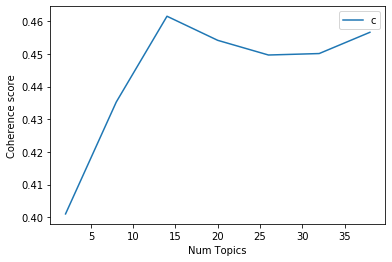

In [14]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
num_topics = 5
chunksize = 500 
passes = 80 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.043*"neuropsychological_test" + 0.037*"d000368_aged" + 0.027*"d000368" + 0.024*"test" + 0.023*"d060825_cognitive" + 0.022*"neuropsychological" + 0.022*"d009483" + 0.019*"disease" + 0.015*"d012146_rest" + 0.014*"d009483_neuropsychological"'), (1, '0.067*"processing_computer" + 0.028*"computer" + 0.026*"d008959_model" + 0.026*"assisted" + 0.023*"image" + 0.023*"processing" + 0.020*"d007091" + 0.020*"d007091_image" + 0.020*"d006801_human_d007091_image" + 0.017*"model"'), (2, '0.054*"d002540_cerebral" + 0.035*"d001288_attention" + 0.028*"cortex" + 0.027*"d002540" + 0.026*"cerebral" + 0.021*"d000293_adolescent" + 0.019*"d011597_psychomotor" + 0.019*"attention" + 0.018*"d056344_executive" + 0.018*"d003071_cognition"'), (3, '0.104*"default_mode" + 0.066*"functional_connectivity" + 0.053*"default" + 0.052*"mode" + 0.045*"resting_state" + 0.030*"connectivity" + 0.024*"state" + 0.022*"resting" + 0.022*"magnetic_resonance" + 0.021*"fmri"'), (4, '0.034*"d006179_gyrus" + 0.026*"d017397_pref

In [20]:
#n_topics = 5
#n_top_words = 9
#my_lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=120, minimum_probability=0)
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.014968  0.188256       1        1  27.929148
1     -0.220532  0.133306       2        1  23.963804
0     -0.181995 -0.245922       3        1  22.916847
3      0.196452 -0.169966       4        1  13.624245
2      0.221042  0.094326       5        1  11.565952, topic_info=                                 Term        Freq       Total Category  \
4                        default_mode  334.000000  334.000000  Default   
413               processing_computer  382.000000  382.000000  Default   
35            functional_connectivity  214.000000  214.000000  Default   
3                             default  170.000000  170.000000  Default   
10                               mode  167.000000  167.000000  Default   
..                                ...         ...         ...      ...   
147                           d000293   43.814762  140.796371   Topic5   
504                              time   28.217794   42.652874   Topic5   
194                d063132_connectome   33.448181  127.394463   Topic5   
95                              child   28.379005   53.672848   Topic5   
484  d000293_adolescent_d000328_adult   29.130407   91.273827   Topic5   

     logprob  loglift  
4    30.0000  30.0000  
413  29.0000  29.0000  
35   28.0000  28.0000  
3    27.0000  27.0000  
10   26.0000  26.0000  
..       ...      ...  
147  -4.1320   0.9898  
504  -4.5720   1.7440  
194  -4.4019   0.8198  
95   -4.5663   1.5198  
484  -4.5402   1.0150  

[266 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
146       1  0.482424          adolescent
146       2  0.190252          adolescent
146       4  0.020384          adolescent
146       5  0.305762          adolescent
91        3  0.793519               aging
...     ...       ...                 ...
606       3  0.958806          tomography
559       2  0.094300              visual
559       5  0.880131              visual
595       1  0.951682                with
596       1  0.990999  with_hyperactivity

[318 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 3])